In [14]:
import gpytorch
import torch
import math
import matplotlib.pyplot as plt

In [15]:
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 50

# Training data is 100 points in [0,1] inclusive regularly spaced
train_x = torch.linspace(0, 1, 100)
# True function is sin(2*pi*x) with Gaussian noise
train_y = torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * math.sqrt(0.04)

# Wrap training, prediction and plotting from the ExactGP-Tutorial into a function,
# so that we do not have to repeat the code later on
def train(model, likelihood, training_iter=training_iter):
    # Use the adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    for i in range(training_iter):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = model(train_x)
        # Calc loss and backprop gradients
        loss = -mll(output, train_y)
        loss.backward()
        optimizer.step()


def predict(model, likelihood, test_x = torch.linspace(0, 1, 51)):
    model.eval()
    likelihood.eval()
    # Make predictions by feeding model through likelihood
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        # Test points are regularly spaced along [0,1]
        return likelihood(model(test_x))

def plot(observed_pred, test_x=torch.linspace(0, 1, 51)):
    with torch.no_grad():
        # Initialize plot
        f, ax = plt.subplots(1, 1, figsize=(4, 3))

        # Get upper and lower confidence bounds
        lower, upper = observed_pred.confidence_region()
        # Plot training data as black stars
        ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
        # Plot predictive means as blue line
        ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
        # Shade between the lower and upper confidence bounds
        ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
        ax.set_ylim([-3, 3])
        ax.legend(['Observed Data', 'Mean', 'Confidence'])

In [20]:
class LLSKernel(gpytorch.kernels.Kernel):
    # the sinc kernel is stationary
    is_stationary = False

    # We will register the parameter when initializing the kernel
    def __init__(self, length_prior=None, length_constraint=None, **kwargs):
        super().__init__(**kwargs)

        # register the raw parameter
        self.register_parameter(
            name='lengthscale', parameter=torch.nn.Parameter(torch.zeros(*self.batch_shape, 1, 1))
        )

        # set the parameter constraint to be positive, when nothing is specified
        if length_constraint is None:
            length_constraint = Positive()

        # register the constraint
        self.register_constraint("raw_length", length_constraint)

        # set the parameter prior, see
        # https://docs.gpytorch.ai/en/latest/module.html#gpytorch.Module.register_prior
        if length_prior is not None:
            self.register_prior(
                "length_prior",
                length_prior,
                lambda m: m.length,
                lambda m, v : m._set_length(v),
            )

    # now set up the 'actual' paramter
    @property
    def length(self):
        # when accessing the parameter, apply the constraint transform
        return self.raw_length_constraint.transform(self.raw_length)

    @length.setter
    def length(self, value):
        return self._set_length(value)

    def _set_length(self, value):
        if not torch.is_tensor(value):
            value = torch.as_tensor(value).to(self.raw_length)
        # when setting the paramater, transform the actual value to a raw one by applying the inverse transform
        self.initialize(raw_length=self.raw_length_constraint.inverse_transform(value))
    
    # this is the kernel function
    def forward(self, x1, x2, **params):
        # calculate the distance between inputs
        diff = self.covar_dist(x1, x2, **params)
        # prevent divide by 0 errors
        diff.where(diff == 0, torch.as_tensor(1e-20))
        # return sinc(diff) = sin(diff) / diff
        return torch.exp(-torch.square(diff))
    
# Use the simplest form of GP model, exact inference
class FirstGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = FirstSincKernel()

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

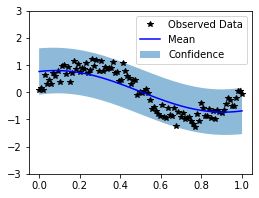

In [21]:
# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = FirstGPModel(train_x, train_y, likelihood)

# set to training mode and train
model.train()
likelihood.train()
train(model, likelihood)

# Get into evaluation (predictive posterior) mode and predict
model.eval()
likelihood.eval()
observed_pred = predict(model, likelihood)
# plot results
plot(observed_pred)